In [48]:
import mne
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import numpy as np
from copy import copy
import os
from mne.preprocessing import ICA

In [71]:
filename = r'subj04_01_TSlf.vhdr'

goods = ['AA_eeg', 'AB_eeg', 'AM_eeg', 'BN_eeg', 'DD_eeg', 'DK_eeg', 'DT_eeg', 'IK_eeg', 'IM_eeg', 'LD_eeg', 'LJ_eeg', 'MI_eeg', 'NB_eeg', 'NH_eeg', 'SG_eeg']

globpath = r"C:\Users\Admin\Desktop\EEG_analysis\DK_eeg\\"
os.chdir(globpath)
subj_name = globpath[-7:-4]

new_dir = r'C:\Users\Admin\Desktop\EEG_analysis\ERD_pictures'

path_to_save_pics = [new_dir,  subj_name]
path_to_save_pics = ''.join(path_to_save_pics)
os.makedirs(str(path_to_save_pics), exist_ok=True)
print(path_to_save_pics, subj_name)

C:\Users\Admin\Desktop\EEG_analysis\ERD_picturesK_e K_e


In [72]:
###IMPORT
#path = '/Users/leojack/Desktop/laba/EEG128/LJ_eeg/LJ05_TS_Ear.vhdr'
raw = mne.io.read_raw_brainvision(filename,  preload=True)

# raw_1 = mne.io.read_raw_brainvision(r'subj06_TI_rf_01.vhdr',  preload=True)
# raw_2 = mne.io.read_raw_brainvision(r'subj06_TI_rf_02.vhdr',  preload=True)
# raw = mne.concatenate_raws([raw_1, raw_2], preload = True)

def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

###PREPROCESSING
mne.set_eeg_reference(raw)
raw.filter(0.1, 30, fir_design='firwin', skip_by_annotation='edge')
events, ids = mne.events_from_annotations(raw)

Extracting parameters from subj04_01_TSlf.vhdr...
Setting channel info structure...
Reading 0 ... 455099  =      0.000 ...   455.099 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33001 samples (33.001 sec)

Used Annotations descriptions: ['New Segment/', 'Rest1/R  1', 'Vibro0/V  1']


In [73]:
# print(events)
# print(ids)
# raw.info.ch_names.index('C3')

In [ ]:
def preproc_eeg(raw_path):
    raw = mne.io.read_raw_brainvision(filename,  preload=True)

# raw_1 = mne.io.read_raw_brainvision(r'subj06_TI_rf_01.vhdr',  preload=True)
# raw_2 = mne.io.read_raw_brainvision(r'subj06_TI_rf_02.vhdr',  preload=True)
# raw = mne.concatenate_raws([raw_1, raw_2], preload = True)

    def removekey(d, key):
        r = dict(d)
        del r[key]
        return r

    ###PREPROCESSING
    mne.set_eeg_reference(raw)
    raw.filter(0.1, 30, fir_design='firwin', skip_by_annotation='edge')
    events, ids = mne.events_from_annotations(raw)
    
    events_to_exclude = [99999, 12]
    events = mne.pick_events(events, exclude=events_to_exclude)


    try:
        ids = removekey(ids, 'New Segment/')
    except KeyError:
        pass

    try:
        ids = removekey(ids, 'Stimulus/S 12')
    except KeyError:
        pass

    ids['smr'] = ids.pop('Motor/M  1')
    ids['rest'] = ids.pop('Rest1/R  1')
    
    epochs = mne.Epochs(raw, events, event_id=ids, tmin=0.0, tmax=5.0, baseline=(0, 0), preload=True)     

    
    
    

In [62]:
events_to_exclude = [99999, 12]
events = mne.pick_events(events, exclude=events_to_exclude)


try:
    ids = removekey(ids, 'New Segment/')
except KeyError:
    pass

try:
    ids = removekey(ids, 'Stimulus/S 12')
except KeyError:
    pass

ids['vibro'] = ids.pop('Vibro0/V  1')
ids['rest'] = ids.pop('Rest1/R  1')

%matplotlib auto
#raw.plot(block=True)
 
# raw.plot(block=True, events = events,  event_id=ids)
original_bads = ['TP9', 'TP8', 'TTP7h', 'TPP10h', 'TTP8h', 'P10']
raw.info['bads'] = original_bads 
raw.interpolate_bads( reset_bads=True, method=dict(eeg='MNE'), verbose=False)

###EPOCHS
epochs = mne.Epochs(raw, events, event_id=ids, tmin=0.0, tmax=6.0, baseline=(0, 0), preload=True)     


Using matplotlib backend: Qt5Agg
Not setting metadata
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 60 events and 6001 original time points ...
0 bad epochs dropped


In [68]:
###FULL SPECTRUM CALCULATION
rst_full, ffreqs = mne.time_frequency.psd_multitaper(epochs['rest'],fmin = 1, fmax = 30, normalization='full')
ts_full, ffreqs = mne.time_frequency.psd_multitaper(epochs['vibro'], fmin = 1, fmax = 30, normalization='full')

rst_full = 10 * np.log10(rst_full)  # convert to dB
ts_full = 10 * np.log10(ts_full)

###FULL SPECTRUM VIZUALIZATION
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.1)

if '_rh' or '_rf' in filename:
    sns.lineplot(x=ffreqs, y=rst_full.mean(0)[raw.info.ch_names.index('C3')],color='black', label="покой", linewidth=1.5)
    sns.lineplot(x=ffreqs, y=ts_full.mean(0)[raw.info.ch_names.index('C3')], color='red', label='тактильная стимуляция', linewidth=1.5)
    print('Plotting on data from C3')
elif '_lh' or '_rf' in filename:
    sns.lineplot(x=ffreqs, y=rst_full.mean(0)[raw.info.ch_names.index('C4')],color='black', label="покой", linewidth=1.5)
    sns.lineplot(x=ffreqs, y=ts_full.mean(0)[raw.info.ch_names.index('C4')], color='red', label='тактильная стимуляция', linewidth=1.5)
    print('Plotting on data from C4')
elif '_rl' or '_ll' in filename:
    sns.lineplot(x=ffreqs, y=rst_full.mean(0)[raw.info.ch_names.index('Cz')],color='black', label="покой", linewidth=1.5)
    sns.lineplot(x=ffreqs, y=ts_full.mean(0)[raw.info.ch_names.index('Cz')], color='red', label='тактильная стимуляция', linewidth=1.5)
    print('Plotting on data from Cz')

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting on data from C3


In [36]:
# rst_full

In [69]:
### PSD CALCULATION FOR TOPOMAPS
minimal_freq = 9.5
maximal_freq = 12.0
rst, ffreqs = mne.time_frequency.psd_welch(epochs['rest'],fmin = minimal_freq, fmax = maximal_freq, n_fft=1000, n_overlap=1000*0.8)
ts, ffreqs = mne.time_frequency.psd_welch(epochs['vibro'], fmin = minimal_freq, fmax = maximal_freq, n_fft=1000, n_overlap=1000*0.8)
####ERD FOR TOPOMAPS
rst_med = np.median(rst.mean(2), axis=0)
smr_med = np.median(ts.mean(2), axis=0)
erd_percents = pd.DataFrame(data=(rst_med-smr_med)/rst_med*100, index=raw.ch_names)[0]
erd_dB = pd.DataFrame(data=10*np.log10(rst_med/smr_med), index=raw.ch_names)[0]

###TOPOMAP VIZ
#raw.plot_sensors()

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


In [81]:
os.chdir(path_to_save_pics)

fig1, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5), squeeze=False)
ax = axes[0]
fig1 = mne.viz.plot_topomap(erd_percents, raw.info)
ax[0].set_title('ERD percentage. Frequency range:' + str(minimal_freq) + '-' + str(maximal_freq) + 'Hz')


custom_name = None
# custom_name = 'theta_ES_TS'
pic_name = 0
if custom_name:
    pic_name = [custom_name, '_percentage', '.png']
else:
    pic_name = [filename[0:14], '_percentage', '.png']



pic_name = ''.join(pic_name)
plt.savefig(pic_name)



In [70]:
fig2, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5), squeeze=False)
ax = axes[0]
fig2 = mne.viz.plot_topomap(erd_dB, raw.info)
# ax[0].set_title('ERD in dB. Frequency range:' + str(minimal_freq) + '-' + str(maximal_freq) + 'Hz')

pic_name = 0

custom_name = None
# custom_name = 'IM_TS_LH_9.7-10.4 Hz'
if custom_name:
    
    pic_name = [custom_name, '_dB', '.png']
else:
    pic_name = [filename[0:14], '_dB', '.png']

pic_name = ''.join(pic_name)
# plt.savefig(pic_name)

    Using multitaper spectrum estimation with 7 DPSS windows


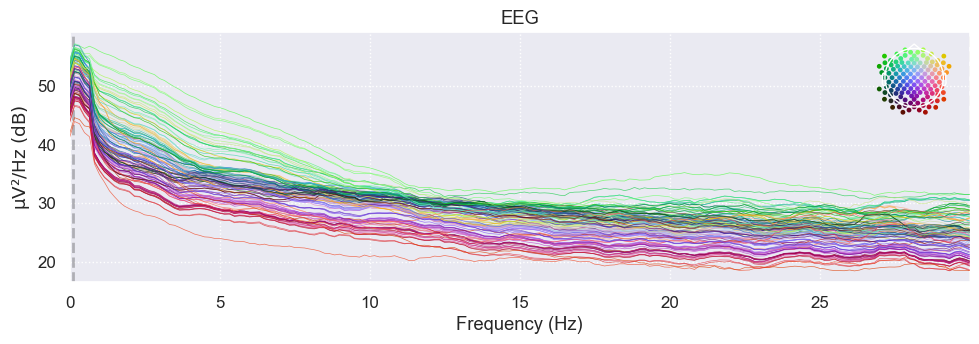

In [37]:
# chanels = pd.DataFrame(raw.info.ch_names)
# chanels.head(50)
#bads_eliminated.plot()
#bads_eliminated.plot_sensors()
# epochs.plot(block=True)
# #print(raw.info['bads'])
# #bads_eliminated.plot_psd(fmax=30)
# #epochs.interpolate_bads( reset_bads=True, method=dict(eeg='MNE'), verbose=True)
epochs['rest'].plot_psd(fmax=30)
# epochs['vibro'].plot_psd(fmax=30)


In [39]:
%matplotlib auto
raw.plot(block=True)
#raw.interpolate_bads( reset_bads=True, method=dict(eeg='MNE'), verbose=True)
#bads_eliminated.plot_psd(fmax=30)
picks = mne.pick_channels_regexp(raw.ch_names, regexp='T.|P.')


Using matplotlib backend: Qt5Agg
Channels marked as bad: none


In [67]:
vibro_epochs

Number of events,19
Events,vibro: 19
Time range,0.000 – 6.000 sec
Baseline,0.000 – 0.000 sec


In [77]:
vibro_epochs = epochs['vibro']
rest_epochs = epochs['rest']


# vibro_epochs.plot_image(picks=['C3'])

frequencies = np.linspace(5,35,100)
n_cycles = frequencies  # different number of cycle per frequency
vibro_epochs_4power = vibro_epochs.copy().pick_channels(['CP2', 'CP4', "C2", "C4"])
power = mne.time_frequency.tfr_morlet(vibro_epochs_4power, freqs=frequencies, n_cycles=n_cycles, use_fft=False,
                        return_itc=0, decim=1, n_jobs=1)
power.apply_baseline([5,6], mode='logratio',)
left_hand_electrodes = ['CP2', 'CP4', "C2", "C4"]
right_hand_electrodes = ['CP3', 'CP5', "C3", "C5"]

if "_l" or "_L" in filename:
    
#     _, axis = plt.subplots(2, 2)
    
#     fig1 = power.plot(left_hand_electrodes[0])
#     axis[0, 0].set_title(left_hand_electrodes[0])
#     plt.subplot(211)


#     fig2 = power.plot(left_hand_electrodes[1])
#     axis[1, 1].set_title(left_hand_electrodes[1])
#     plt.subplot(212)

    
#     fig3 = power.subplot(left_hand_electrodes[2])
#     axis[1, 0].set_title(left_hand_electrodes[2])
#     plt.subplot(223)

    
#     fig4 = power.plot(left_hand_electrodes[3])
#     axis[0, 1].set_title(left_hand_electrodes[3])
#     plt.subplot(224)

#     # Combine all the operations and display
#     plt.show()
    
    

    power.plot(picks=left_hand_electrodes[0])
    power.plot(picks=left_hand_electrodes[1])
    power.plot(picks=left_hand_electrodes[2])
    power.plot(picks=left_hand_electrodes[3])
    


    plt.show()

else:
    pass
#     power.plot(['CP3', 'CP5', "C3", "C5"])


Applying baseline correction (mode: logratio)
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


In [ ]:
power

In [66]:
power.plot(picks=left_hand_electrodes[0])

No baseline correction applied


[<Figure size 640x480 with 2 Axes>]

In [50]:
# %matplotlib auto
# raw.plot(order=picks, n_channels=len(picks))

print(type(fig1), fig1)
# power.plot()
help(plt.plot)

<class 'list'> [<Figure size 640x480 with 1 Axes>]
Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance

Dropped 0 epochs: 
Channels marked as bad: none


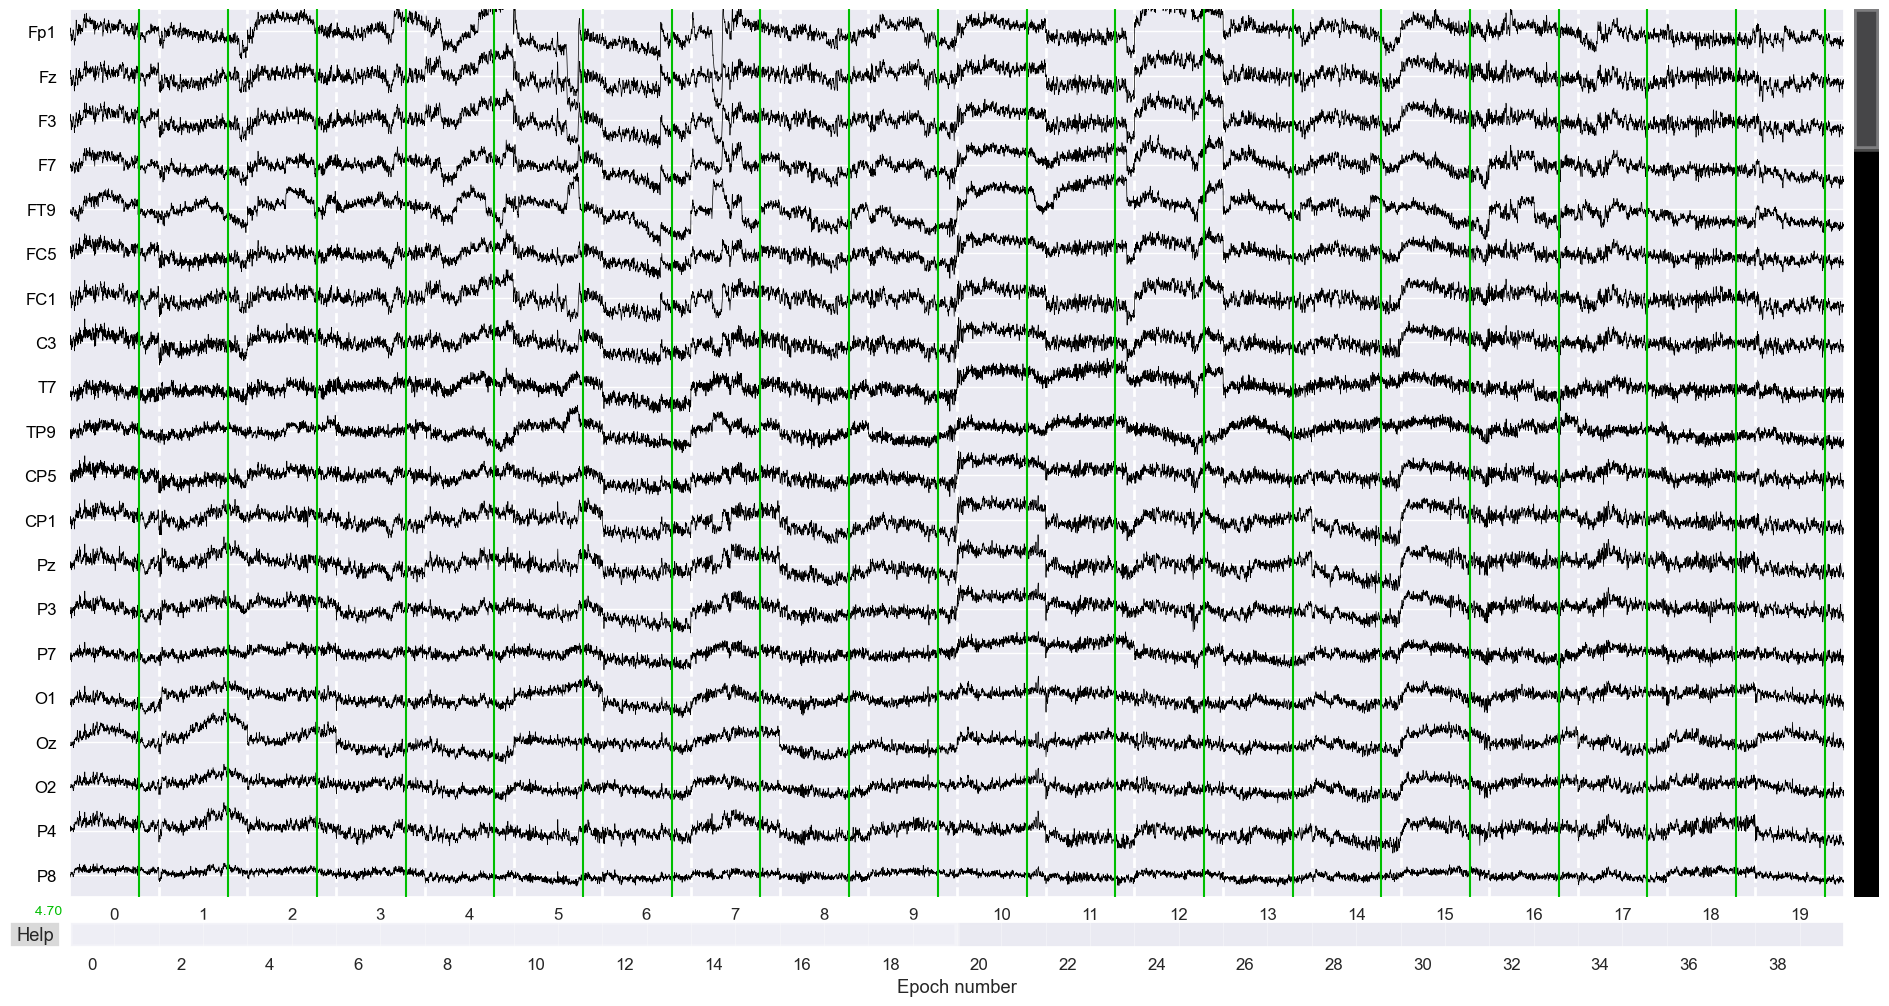

In [44]:
epochs.plot(block=True)


In [107]:
fig = mne.viz.plot_topomap(erd_percents, raw.info)
fig.set_title('Frequency range:' + str(minimal_freq) + '-' + str(maximal_freq) + 'Hz', fontweight='bold')

AttributeError: 'tuple' object has no attribute 'set_title'

In [115]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
mne.viz.plot_topomap(erd_percents, raw.info, axes=ax[0], show=False)
mne.viz.plot_topomap(erd_dB, raw.info, axes=ax[1], show=False)
ax[0].set_title('ERD percentage. Frequency range:' + str(minimal_freq) + '-' + str(maximal_freq) + 'Hz')
ax[1].set_title('ERD in dB. Frequency range:' + str(minimal_freq) + '-' + str(maximal_freq) + 'Hz')


Text(0.5, 1.0, 'ERD in dB. Frequency range:7-14Hz')

In [128]:
fig = mne.viz.plot_topomap(erd_percents, raw.info, show=False)
set_title('ERD percentage. Frequency range:' + str(minimal_freq) + '-' + str(maximal_freq) + 'Hz')

AttributeError: module 'mne' has no attribute 'plot_topomap'

In [132]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,3), squeeze=False)

ax = axes[0]
fig = mne.viz.plot_topomap(erd_percents, raw.info)
ax[0].set_title('ERD percentage. Frequency range:' + str(minimal_freq) + '-' + str(maximal_freq) + 'Hz')
# ax = axes[0]
# mne.viz.topomap.plot_topomap(temp,l.pos,axis=ax)

Text(0.5, 1.0, 'ERD percentage. Frequency range:7-14Hz')

In [3]:
df = pd.read_csv(r'C:\Users\Admin\Desktop\freq ranges.txt')
print(df['min'].median(), df['max'].median())
print(df['min'].mean(), df['max'].mean())


10.25 11.25
10.45 11.55


In [6]:
filename = r'C:\Users\Admin\Desktop\MANY PIPELINES\eeg_brainvision\EMP01.vhdr'
raw = mne.io.read_raw_brainvision(filename,  preload=True)
mne.set_eeg_reference(raw)
raw.filter(0.1, 30, fir_design='firwin', skip_by_annotation='edge')
events, ids = mne.events_from_annotations(raw)

Extracting parameters from C:\Users\Admin\Desktop\MANY PIPELINES\eeg_brainvision\EMP01.vhdr...
Setting channel info structure...
Reading 0 ... 2541055  =      0.000 ...  4962.998 secs...


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16897 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/1030', 'Stimulus/1031', 'Stimulus/1039', 'Stimulus/1040', 'Stimulus/1041', 'Stimulus/1049', 'Stimulus/1110', 'Stimulus/1111', 'Stimulus/1119', 'Stimulus/1120', 'Stimulus/1121', 'Stimulus/1129', 'Stimulus/2030', 'Stimulus/2031', 'Stimulus/2039', 'Stimulus/2040', 'S

In [16]:
ids

{'New Segment/': 99999,
 'Stimulus/1030': 10001,
 'Stimulus/1031': 10002,
 'Stimulus/1039': 10003,
 'Stimulus/1040': 10004,
 'Stimulus/1041': 10005,
 'Stimulus/1049': 10006,
 'Stimulus/1110': 10007,
 'Stimulus/1111': 10008,
 'Stimulus/1119': 10009,
 'Stimulus/1120': 10010,
 'Stimulus/1121': 10011,
 'Stimulus/1129': 10012,
 'Stimulus/2030': 10013,
 'Stimulus/2031': 10014,
 'Stimulus/2039': 10015,
 'Stimulus/2040': 10016,
 'Stimulus/2041': 10017,
 'Stimulus/2049': 10018,
 'Stimulus/2091': 10019,
 'Stimulus/2110': 10020,
 'Stimulus/2111': 10021,
 'Stimulus/2119': 10022,
 'Stimulus/2120': 10023,
 'Stimulus/2121': 10024,
 'Stimulus/2129': 10025,
 'Time 0/': 10026}

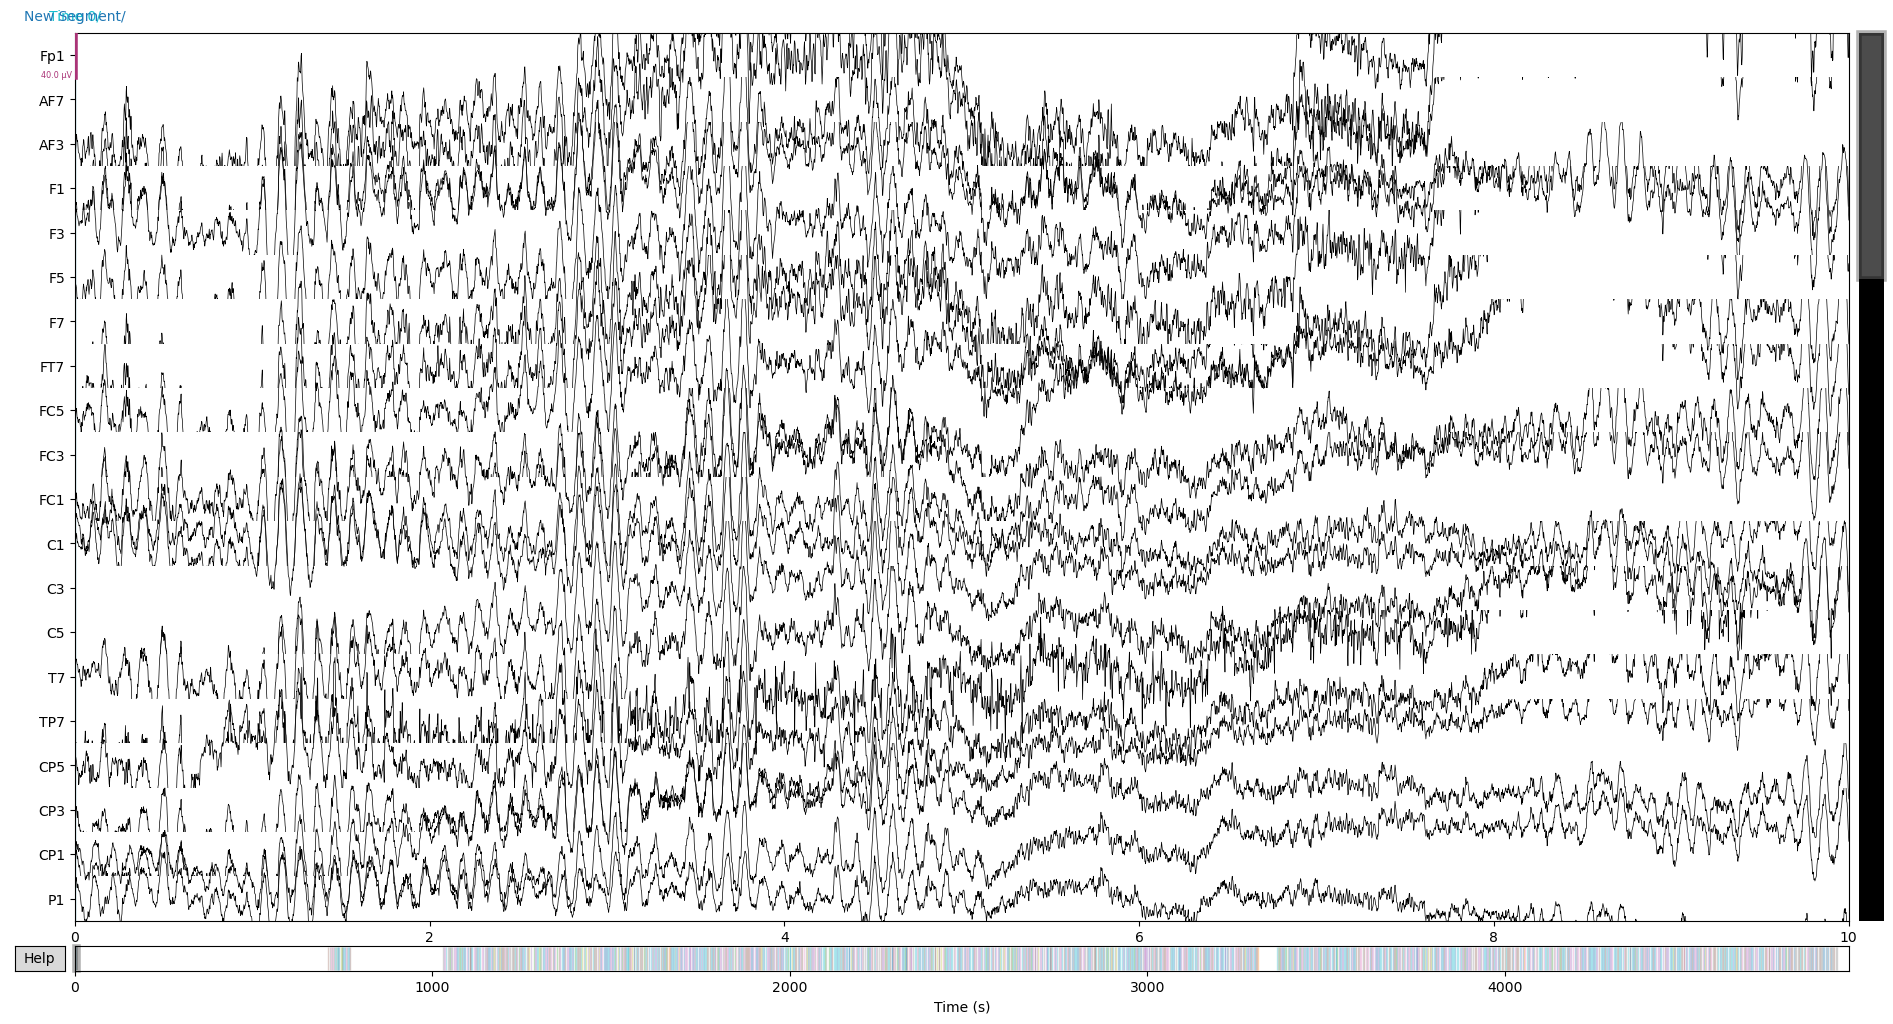

Channels marked as bad: none


In [12]:
raw.plot()

<ipython-input-21-c5fc4a38815d>:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events)


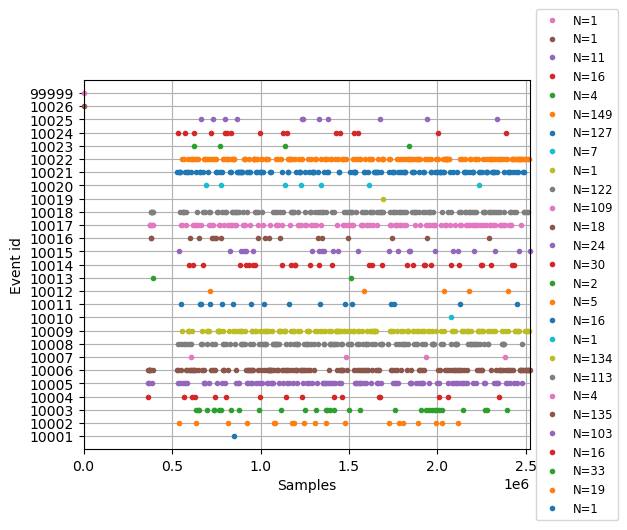

In [21]:
mne.viz.plot_events(events)

In [ ]:
mne.samples.fetch_fsaverage([subjects_dir, verbose])